In [10]:
import os
from dotenv import load_dotenv
import snowflake.connector
import pandas as pd
import plotly.express as px
# Use Plotly's "make_subplots" function from "plotly.subplots" to layout elements horizontally
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Load credentials
load_dotenv()

True

In [11]:
# Connect to Snowflake
conn = snowflake.connector.connect(
    user=os.getenv('SNOWFLAKE_USER'),
    password=os.getenv('SNOWFLAKE_PASSWORD'),
    account=os.getenv('SNOWFLAKE_ACCOUNT') + '.' + os.getenv('SNOWFLAKE_REGION'),
    warehouse=os.getenv('SNOWFLAKE_WAREHOUSE'),
    database='WALMART_DB',
    schema='SILVER',
    role=os.getenv('SNOWFLAKE_ROLE')
)

In [12]:
# SQL query
# After an initial run, I saw sales numbers up to 30B.  This seemed very
# high to me. After further investigation, I found that multiple stores
# share the same size.  This means we're aggregating weekly sales across
# multiple stores when the store sizes match. The only way I found to 
# address this was to take the average sales between all stores that had
# the same size.  For stores with no store size duplicates, the weekly
# sales and average weekly sales will be identical.
# sql = """
# SELECT 
#   wsd.store_size,
#   COUNT(wft.store_id) AS store_count,
#   SUM(wft.store_weekly_sales) AS weekly_sales,
#   SUM(wft.store_weekly_sales) / COUNT(wft.store_id) AS avg_sales_per_store
# FROM 
#   walmart_fact_table wft
# JOIN
#   walmart_store_dim wsd
# ON
#   wft.store_id = wsd.store_id
# GROUP BY 1
# ORDER BY 1
# """

# In an attempt to match the area chart included in the project documentation,
# the SQL below was used.
sql = """
SELECT 
    wdd.year,
    COALESCE(SUM(wft.markdown1),0) AS markdown1,
    COALESCE(SUM(wft.markdown2),0) AS markdown2,
    COALESCE(SUM(wft.markdown3),0) AS markdown3,
    COALESCE(SUM(wft.markdown4),0) AS markdown4,
    COALESCE(SUM(wft.markdown5),0) AS markdown5
FROM 
    WALMART_DB.SILVER.walmart_fact_table wft
JOIN
    WALMART_DB.SILVER.walmart_date_dim wdd
ON
    wft.date_id = wdd.date_id
GROUP BY 1
ORDER BY 1
"""

# The following SQL is for the summary chart section in the report.

sql_summary_table = """
SELECT 
    wdd.year,
    wft.store_id,
    SUM(wft.markdown1) AS markdown1,
    SUM(wft.markdown2) AS markdown2,
    SUM(wft.markdown3) AS markdown3,
    SUM(wft.markdown4) AS markdown4,
    SUM(wft.markdown5) AS markdown5
FROM 
    WALMART_DB.SILVER.walmart_fact_table wft
JOIN
    WALMART_DB.SILVER.walmart_date_dim wdd
ON
    wft.date_id = wdd.date_id
WHERE 
    wft.markdown1 IS NOT NULL
AND
    wft.markdown2 IS NOT NULL
AND
    wft.markdown3 IS NOT NULL
AND
    wft.markdown4 IS NOT NULL
AND
    wft.markdown5 IS NOT NULL
GROUP BY 1,2
ORDER BY 1,2
"""

# Run query using Snowflake connector
cur = conn.cursor()
cur.execute(sql)

# Load results into DataFrame
columns = [col[0] for col in cur.description]
data = cur.fetchall()
df = pd.DataFrame(data, columns=columns)

# Force column names to lowercase so Snowflake will match the model table
df.columns = [col.lower() for col in df.columns]

# print(df.columns)

# Convert the store size to a string 
# plotly create a more managable range for the y-axis
# df['store_size'] = df['store_size'].astype(str)


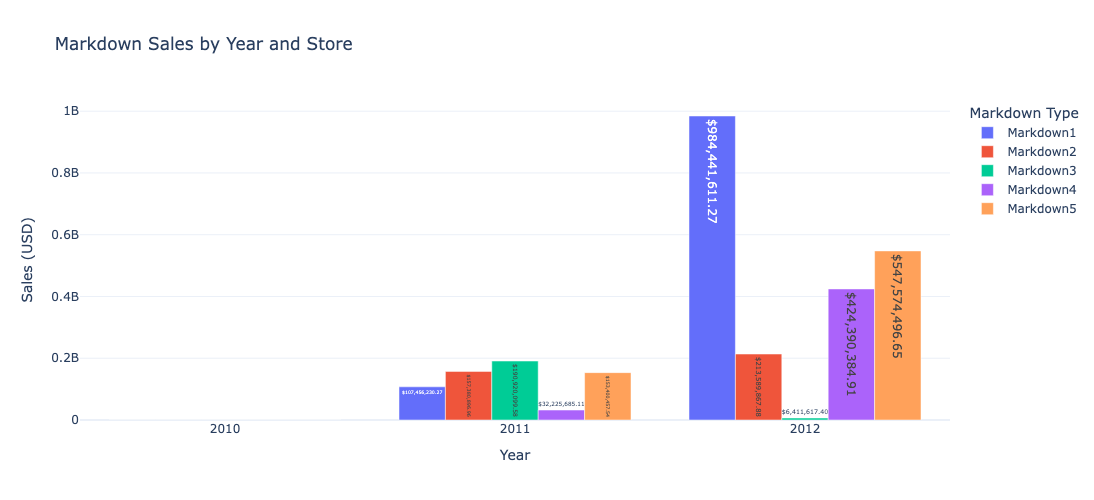

In [4]:
# THIS CHART IS FOR MARKDOWN SALES BY YEAR, WITH A GROUPED BAR CHART
# Plot using Plotly

# Create a list of the years as a string for a clean display.
# Otherwise, Plotly can interpret the values as integers and try
# to format them as such.
years = df['year'].astype(str).tolist()

# Initialize an empty Figure container for the plot
fig = go.Figure()

# Here's where the meat of the bar chart is assembled.
# Loop through the markdowns and add a bar for each, for
# each year.
# The add_trace() function takes a go.Bar() parameter which
# supplies all the data for that particular trace object.
for col in ['markdown1','markdown2','markdown3','markdown4','markdown5']:
    fig.add_trace(
        go.Bar(
            x=years,
            y=df[col],
            name=col.capitalize(),  # Show as "Markdown1", etc
            text=[f"${val:,.2f}" for val in df[col]],
            hovertemplate='%{text}<extra></extra>'
        )
    )

fig.update_layout(
    title="Markdown Sales by Year and Store",
    xaxis_title="Year",
    yaxis_title="Sales (USD)",
    barmode="group",
    template="plotly_white",
    legend_title="Markdown Type",
    height=500,
    width=800
)

fig.show()

In [17]:
# SUMMARY TABLE - Gather all the data
# Load the data into a dataframe
pd.set_option('display.width', 1500)
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.max_rows', 300)
pd.set_option('display.max_columns', 100)

df_summary = pd.read_sql(sql_summary_table, conn)
summary_data = df_summary.copy()
# print(f"{summary_data.head(20)}\n\n")

# The dataframe columns are:
# Year, Store_ID, Markdown1, Markdown2, Markdown3, Markdown4, Markdown5
# Let's create a totals series starting with column index 2
totals = summary_data.iloc[:, 2:].sum(numeric_only=True)

# Think of a series as an array of key:value pairs. Here, the key for the
# totals series will be Markdown1, Markdown2, etc and the value for each
# will be the sum for that column.

# Now, create a "totals row" (list) to arrange the totals so we can append it to
# our dataframe.  Since we'll be slicing off the first column for our 
# multi-row header, insert the word "Total" in the second column.
totals_row = ["", "Total"] + totals.to_list()
# print(totals_row)

# Append our totals row to our summary_data dataframe
summary_data.loc[len(summary_data.index)] = totals_row

# Force column names to lowercase so Snowflake will match the model table
summary_data.columns = [col.lower() for col in summary_data.columns]

# Convert our Year and Store_Id to strings for safe formatting in our table
summary_data['year'] = summary_data['year'].astype(str)
summary_data['store_id'] = summary_data['store_id'].astype(str)

# Format the values in the MarkdownX columns to currency
for col in summary_data.columns[2:]:
    summary_data[col] = summary_data[col].apply(lambda x: f"${x:,.2f}")

print(summary_data)


/var/folders/90/m9dcfcxn38j0ypf7wjqn_bf80000gp/T/ipykernel_97774/1522674875.py:8: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



    year store_id        markdown1        markdown2        markdown3        markdown4        markdown5
0   2011        1    $2,947,704.73    $3,838,799.58    $4,293,743.04      $712,395.03    $4,331,048.06
1   2011        2    $3,910,352.10    $8,334,134.98    $6,000,285.30    $1,178,492.89    $4,717,955.66
2   2011        3    $1,078,010.51    $1,066,741.19       $78,348.93      $178,775.94      $983,943.28
3   2011        4    $3,076,434.65    $6,524,057.37    $6,834,257.50    $1,264,925.66    $6,252,297.03
4   2011        5      $536,210.74    $1,274,921.56    $2,022,176.50      $135,719.10    $2,065,831.47
5   2011        6    $3,214,928.50    $6,253,602.20    $6,574,960.42      $966,290.09    $4,713,721.13
6   2011        7      $933,451.39    $1,391,654.55    $2,979,768.82      $284,814.59    $1,577,463.92
7   2011        8    $1,717,989.88    $2,920,039.74    $3,537,008.34      $402,304.97    $2,993,246.49
8   2011        9      $622,736.34    $1,030,650.41       $29,188.11     

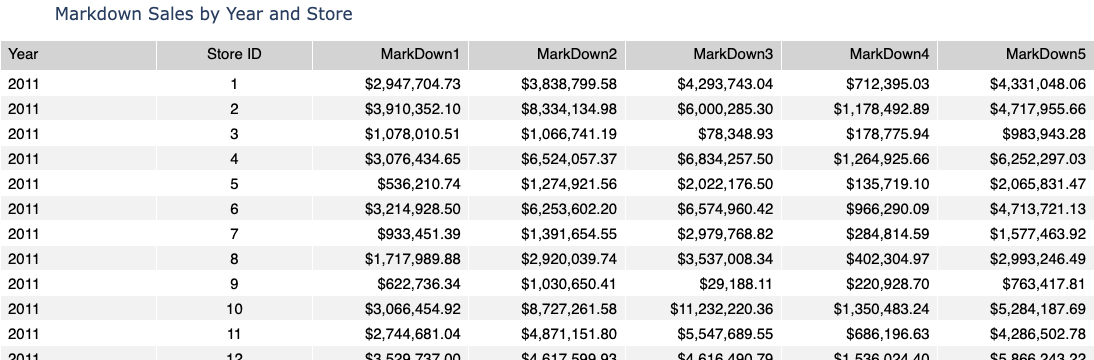

In [23]:
# Use the data from the previous cell to generate the table

# Gather the header values
column_map = {
    'year': 'Year',
    'store_id': 'Store ID',
    'markdown1': 'MarkDown1',
    'markdown2': 'MarkDown2',
    'markdown3': 'MarkDown3',
    'markdown4': 'MarkDown4',
    'markdown5': 'MarkDown5'
}

formatted_headers = [column_map[col] for col in summary_data.columns]

# Prepare zebra striping for the summary table
# Alternate row colors: white for even, light gray for odd.
# We build color lists for each column, with the last row (the total row) as white.
fill_colors = [
    ['white' if i % 2 == 0 else '#f2f2f2' for i in range(len(summary_data) - 1)] + ['white']
    for _ in range(3)
]

# Overwrite the fill color of the final row (the Total row) to a distinct color for emphasis
for i in range(len(fill_colors)):
    fill_colors[i][-1] = 'lavender'

# Now add a bold tag to the total row.  Loop through each column in the last row
# and surround it with the <b></b> tags. Don't be confused by the statement:
# df_weekly_sales.iloc[-1][col]
# This is chaining 2 statements together to fetch the last row first (as a series), then
# fetching the label-based element associated with the variable "col" to get the specific
# element.
for col in summary_data.columns:
    summary_data.loc[len(summary_data)-1, col] = f"<b>{summary_data.iloc[-1][col]}</b>"

# Gather the cell values for the summary data
cell_values = [summary_data[col] for col in summary_data.columns]

# Configure the table using Plotly.  We can't just feed the dataframe
# directly to have the table produced since the required format differs
# slightly from our dataframe layout
fig = go.Figure(data=[
    go.Table(
        header=dict(
            values=formatted_headers,
            fill_color='lightgrey',
            align = ['left','center','right','right','right','right','right'],
            font=dict(size=15, color='black', family='Helvetica'),
            height=30
        ),
        cells=dict(
            values = cell_values,
            fill_color = fill_colors,
            align = ['left','center','right','right','right','right','right'],
            font = dict(size=15, color='black', family='Helvetica'),
            height = 25
        )
    )       
])

fig.update_layout(
    title="Markdown Sales by Year and Store",
    margin=dict(l=0, r=0, t=40, b=0)
)

fig.show()


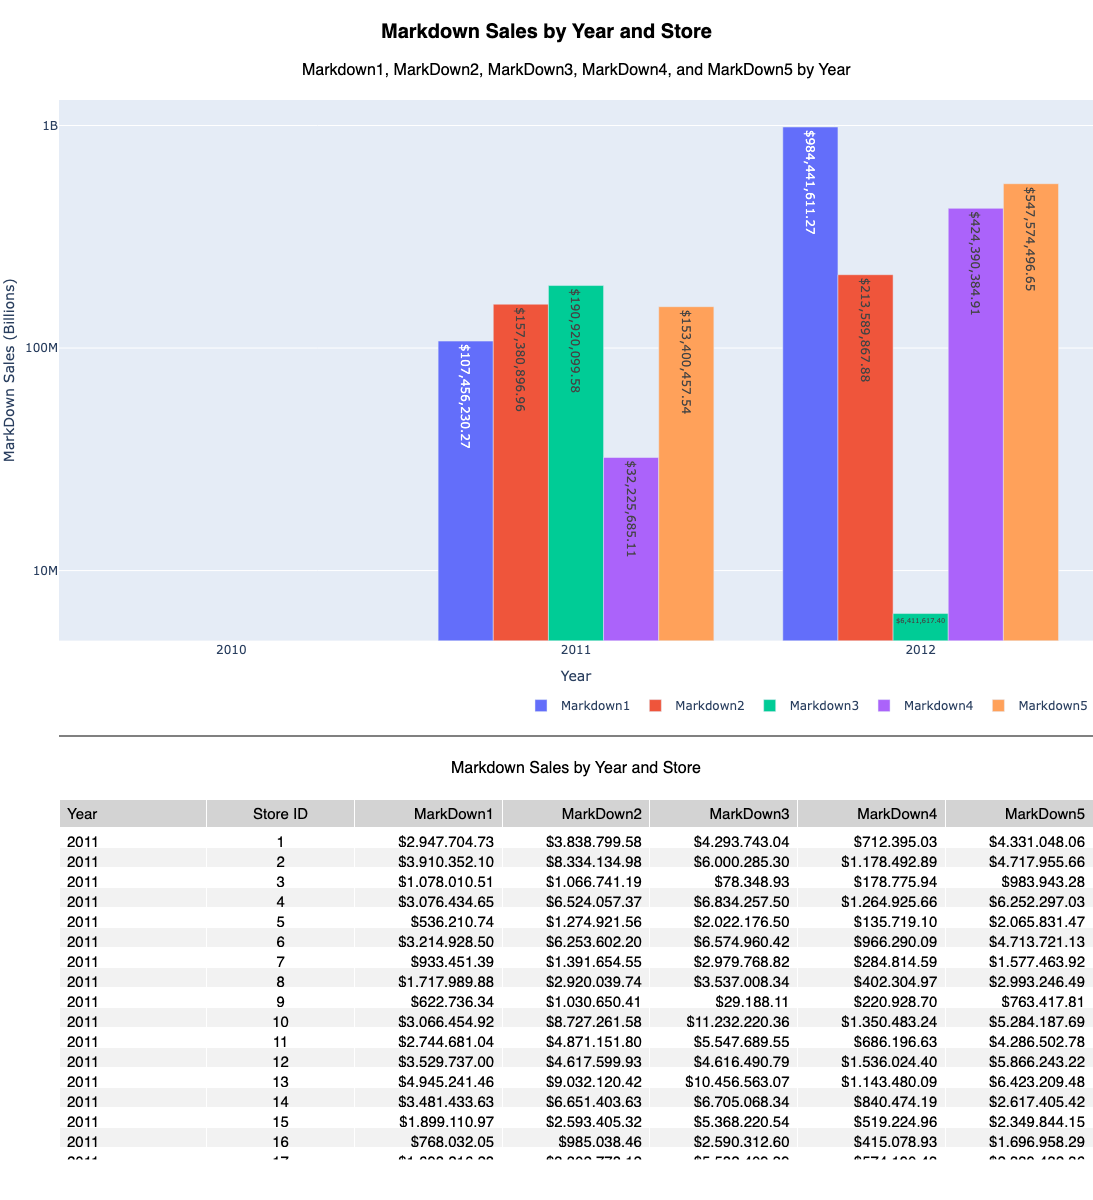

In [59]:
# Let's combine the graph and the summary table into single dashboard-type of presentation
# Given the width of the summary table, let's stack the renderings for clarity in viewing.

# First, let's layout the overall container for the charts
fig = make_subplots(
    rows=2,
    cols=1,
    specs=[
        [{'type': 'xy'}],    # row 1: bar chart
        [{'type': 'domain'}] # row 2: table
    ],
    shared_xaxes=False,
    vertical_spacing=0.15,  # The space between the rows
    row_heights=[0.6, 0.4]
    # subplot_titles=("Markdown Sales by Year", "Markdown Sales by Year and Store")
)

# ============================

# Next, let's add the grouped bar chart to the first cell in column 1
for col in ['markdown1','markdown2','markdown3','markdown4','markdown5']:
    fig.add_trace(
        go.Bar(
            x=years,
            y=df[col],
            name=col.capitalize(),  # Show as "Markdown1", etc
            text=[f"${val:,.2f}" for val in df[col]],
            hovertemplate = 'Year: %{x}<br>Category: %{name}<br>Sales: %{text}<extra></extra>'
        ),
        row=1,
        col=1
    )

fig.add_annotation(
    text = "Markdown1, MarkDown2, MarkDown3, MarkDown4, and MarkDown5 by Year",
    x = 0.5,  # roughly center of line chart
    y = 1.04,  # above the line chart
    xref = "paper",
    yref = "paper",
    showarrow = False,
    font = dict(size=16, family="Helvetica", color="black")
)

# ============================

# Now add the summary table to layout column 2.  Be sure to use the 
# unformatted summary data in df_summary.

# Prepare zebra striping for the summary table
# Alternate row colors: white for even, light gray for odd.
# We build color lists for each column, with the last row (the total row) as white.
fill_colors = [
    ['white' if i % 2 == 0 else '#f2f2f2' for i in range(len(summary_data) - 1)] + ['white']
    for _ in range(len(summary_data.columns))
]

# Overwrite the fill color of the final row (the Total row) to a distinct color for emphasis
for i in range(len(fill_colors)):
    fill_colors[i][-1] = 'lavender'

# Now add a bold tag to the total row.  Loop through each column in the last row
# and surround it with the <b></b> tags. Don't be confused by the statement:
# df_weekly_sales.iloc[-1][col]
# This is chaining 2 statements together to fetch the last row first (as a series), then
# fetching the label-based element associated with the variable "col" to get the specific
# element.
for col in summary_data.columns:
    summary_data.loc[len(summary_data)-1, col] = f"<b>{summary_data.iloc[-1][col]}</b>"

# Gather the cell values for the summary data
cell_values = [summary_data[col] for col in summary_data.columns]
    
# Create the table trace first
table_trace = go.Table(
        header=dict(
            values = formatted_headers,  # From previous cell
            fill_color = 'lightgrey',
            align = ['left','center','right','right','right','right','right'],
            font = dict(size=15, color='black', family='Helvetica')
        ),
        cells=dict(
            values = cell_values,
            fill_color = fill_colors,
            align = ['left','center','right','right','right','right','right'],
            font = dict(size=15, color='black', family='Helvetica')
        )
    )

fig.add_trace(table_trace, row=2, col=1)

fig.add_annotation(
    text = "Markdown Sales by Year and Store",
    x = 0.5,  # roughly center of line chart
    y = 0.37,  # above the line chart
    xref = "paper",
    yref = "paper",
    showarrow = False,
    font = dict(size=16, family="Helvetica", color="black")
)


# ==========================

# Update layout
fig.update_layout(
    xaxis_title = 'Year',
    yaxis_title = 'MarkDown Sales (Billions)',
    # yaxis_tickformat=".2s",
    title=dict(
        text="Markdown Sales by Year and Store",
        y=0.99,
        x=0.5,  # Center
        xanchor='center',
        yanchor='top'
    ),
    margin=dict(
        l=0, 
        r=0, 
        t=100, 
        b=40
    ),  # reduce the left/right margin a bit to help with horizontal scrolling
    height=1200,
    showlegend=True,
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=0.415,
        xanchor="right",
        x=1
    )
)

# Because we have a single metric that dominates the chart with a large value,
# modify the y-axis to use log scaling instead of linear scaling to make the
# smaller values (and shorter bars) more significant in the chart without 
# skewing the actual amounts.  Include the row and col designations since we
# are showing this in row1, col1 of a subplot.
fig.update_yaxes(type='log', row=1, col=1)

# If we were to use default labels, Plotly would use the "G" designation to 
# represent "Billions".  Since this would not resonate with users, adopt a
# custom y-axis tick label scheme.  Again, identify the row and column since
# we are working in a subplot.
# Define custom tick values and matching labels
fig.update_yaxes(
    tickvals=[1e5, 1e6, 1e7, 1e8, 1e9, 1e10],  # adjust as needed
    ticktext=["100K", "1M", "10M", "100M", "1B", "10B"],
    row=1,
    col=1
)

# Let's make the report title pop a little more
title_font = dict(size=20, family="Helvetica", color='black', weight='bold')
fig.update_layout(title=dict(text='Markdown Sales by Year and Store', x=0.5, y=0.98, font=title_font))

fig.add_shape(
    type="line",
    x0=0, x1=1,
    y0=0.40, y1=0.40,
    xref="paper", yref="paper",
    line=dict(color="grey", width=2),
    layer="below"
)


fig.show()
    


In [ ]:
# Close the connection
conn.close()